In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math, os, glob
import seaborn as sns
import sys
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels
import pickle
%matplotlib inline

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
claims = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/Claims.csv')
members = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/Members.csv')
drug_count = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DrugCount.csv')
lab_count = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LabCount.csv')
Days_inhospital2 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y2.csv')
Days_inhospital3 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y3.csv')
Primary_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupPrimaryConditionGroup.csv')
Procedure_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupProcedureGroup.csv')

In [4]:
Days_inhospital2 .describe()
Days_inhospital2['DaysInHospital'].value_counts()

0     64269
1      4835
2      2366
3      1453
4       977
5       565
6       373
15      261
7       256
8       173
9       148
10      106
11       80
12       73
13       61
14       42
Name: DaysInHospital, dtype: int64

In [5]:
print(claims.shape)

(2668990, 14)


In [6]:
print(members.shape)

(113000, 3)


In [7]:
print(drug_count.shape)

(818241, 4)


In [8]:
print(lab_count.shape)

(361484, 4)


In [9]:
print(Days_inhospital2.shape)

(76038, 3)


In [10]:
print(Days_inhospital3.shape)

(71435, 3)


In [11]:
claims.count()

MemberID                 2668990
ProviderID               2652726
Vendor                   2644134
PCP                      2661498
Year                     2668990
Specialty                2660585
PlaceSvc                 2661358
PayDelay                 2668990
LengthOfStay               71598
DSFS                     2616220
PrimaryConditionGroup    2657580
CharlsonIndex            2668990
ProcedureGroup           2665315
SupLOS                   2668990
dtype: int64

In [12]:
claims.dtypes

MemberID                   int64
ProviderID               float64
Vendor                   float64
PCP                      float64
Year                      object
Specialty                 object
PlaceSvc                  object
PayDelay                  object
LengthOfStay              object
DSFS                      object
PrimaryConditionGroup     object
CharlsonIndex             object
ProcedureGroup            object
SupLOS                     int64
dtype: object

In [13]:
claims.head(5)

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.000,172193.000,37796.000,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
1,97903248,3316066.000,726296.000,5300.000,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2,2759427,2997752.000,140343.000,91972.000,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
3,73570559,7053364.000,240043.000,70119.000,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
4,11837054,7557061.000,496247.000,68968.000,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [14]:
#Xem xét về giá trị của LengthOfStay trong file Claims
claims[claims.LengthOfStay.notnull()]["MemberID"].count()
claims[claims.LengthOfStay.notnull()]["LengthOfStay"].describe()

count     71598
unique       10
top       1 day
freq      56696
Name: LengthOfStay, dtype: object

In [15]:
#Groupby theo giá trị của LengthOfStay
claims.groupby("LengthOfStay").count()
#tập data not null của LengthOfStay (dùng để phân tích). Thay đổi kiểu data hiện tại của LengthOfStay theo dạng ngày để có thể dễ cho các dự đoán nếu có

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
LengthOfStay,,,,,,,,,,,,,
1 day,56696,55550,55519,56275,56696,56531,56446,56696,52855,55916,56696,56481,56696
1- 2 weeks,1143,1053,1053,1083,1143,1134,1143,1143,1054,991,1143,1141,1143
2 days,6485,6406,6401,6423,6485,6445,6448,6485,5394,6072,6485,6441,6485
2- 4 weeks,961,893,893,932,961,955,961,961,901,908,961,945,961
26+ weeks,2,0,0,1,2,2,2,2,2,2,2,2,2
3 days,3246,3217,3214,3228,3246,3246,3236,3246,2789,2991,3246,3223,3246
4 days,1473,1447,1447,1454,1473,1473,1473,1473,1316,1311,1473,1470,1473
4- 8 weeks,903,877,877,891,903,903,902,903,830,846,903,899,903
5 days,510,496,496,502,510,510,509,510,464,422,510,507,510


In [16]:
#tạo hàm đổi kiểu Lengthofstay
# days thì lấy ngày, weeks thì lấy thứ tự week cao nhất trong range *7
def convert(s):
    try:
        if 'day' in s:
            return int(s[0])
        if 'weeks' in s and s!= '26+ weeks':
            return int(s[3])*7
        else:
            return 26*7
    except:
        pass

In [17]:
convert('2 days')

2

In [18]:
claims['LengthOfStay']= claims["LengthOfStay"].apply(lambda x: convert(x))

In [19]:
claims.groupby("LengthOfStay").count()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
LengthOfStay,,,,,,,,,,,,,
1.000,56696,55550,55519,56275,56696,56531,56446,56696,52855,55916,56696,56481,56696
2.000,6485,6406,6401,6423,6485,6445,6448,6485,5394,6072,6485,6441,6485
3.000,3246,3217,3214,3228,3246,3246,3236,3246,2789,2991,3246,3223,3246
4.000,1473,1447,1447,1454,1473,1473,1473,1473,1316,1311,1473,1470,1473
5.000,510,496,496,502,510,510,509,510,464,422,510,507,510
6.000,179,177,175,179,179,179,179,179,162,119,179,179,179
14.000,1143,1053,1053,1083,1143,1134,1143,1143,1054,991,1143,1141,1143
28.000,961,893,893,932,961,955,961,961,901,908,961,945,961
56.000,903,877,877,891,903,903,902,903,830,846,903,899,903


In [20]:
claims.LengthOfStay.describe()

count   71598.000
mean        2.553
std         7.055
min         1.000
25%         1.000
50%         1.000
75%         1.000
max       182.000
Name: LengthOfStay, dtype: float64

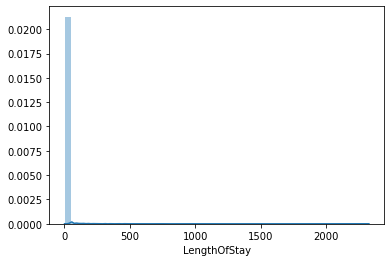

In [21]:
claim_Mem_byLOS = claims[claims.LengthOfStay.notnull()].groupby("MemberID")['LengthOfStay'].sum().reset_index()
sns.distplot(claim_Mem_byLOS["LengthOfStay"])
# Không thể kết luận distribution theo memberID, tức là nhìn chung xu hướng đa số là đi khám rất ngắn ngày, chưa chia theo bất cứ dimension nào 

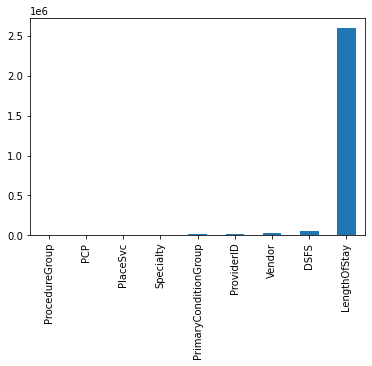

In [22]:
#Check về missing value của từng biến trong bảng claims
missing = claims.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
#Không tính LOS, Condition là variables mà > 50% là missing values => Trên một tập nhỏ no missing value của Condition có thể dùng để xem bệnh nào có LOS cao hơn, nhưng cần xem thêm với các variables khác

In [23]:
# kiểm tra các giá trị categorical 
cate = ['object']
cate_columns = list (claims.select_dtypes(include = cate).columns)
print(cate_columns)

['Year', 'Specialty', 'PlaceSvc', 'PayDelay', 'DSFS', 'PrimaryConditionGroup', 'CharlsonIndex', 'ProcedureGroup']


In [24]:
#Tìm liên hệ giữa các cột categorical với cột LOS_converted
#for col in cate_columns:
    #if col != 'LengthOfStay':
claims[claims.LengthOfStay.notnull()].groupby("Year").LengthOfStay.mean()

Year
Y1   2.340
Y2   2.553
Y3   2.746
Name: LengthOfStay, dtype: float64

In [25]:
claims[claims.LengthOfStay.notnull()].groupby("Specialty").LengthOfStay.mean()
#Số ngày nằm viện của Rehabilitation và Other cao hơn hẳn so với các phương pháp còn lại. Internal (điều trị nội trú) theo logic cao hơn mức trung bình

Specialty
Emergency           1.097
General Practice    1.000
Internal            2.611
Laboratory          1.000
Other              22.393
Rehabilitation     14.000
Surgery             1.013
Name: LengthOfStay, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

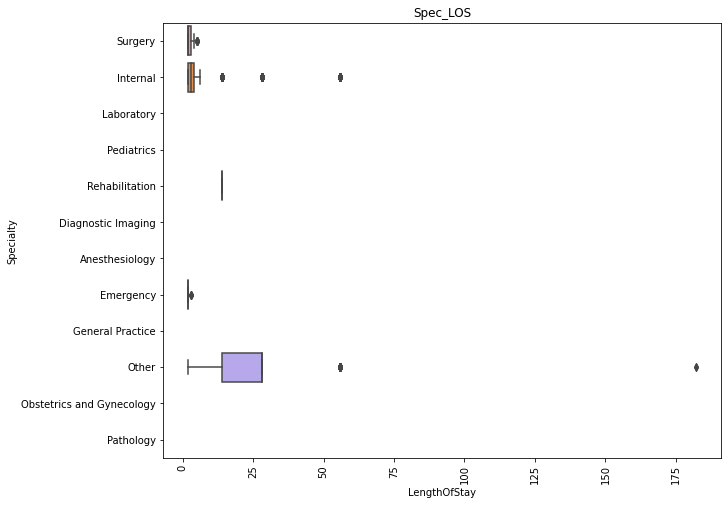

In [27]:
cond1 = claims.LengthOfStay.notnull()
cond2 = claims.Specialty.notnull()
Spec_LOS = claims[~claims.LengthOfStay.isin(cond1) | 
           claims.Specialty.isin(cond2)]
plt.figure(figsize = (10,8))
sns.boxplot(x=Spec_LOS["LengthOfStay"],y=Spec_LOS["Specialty"],data=claims)
plt.xticks(rotation=90)
plt.title('Spec_LOS')
plt.show

In [26]:
claims_Specmem = claims[claims.LengthOfStay.notnull()].groupby("Specialty")['MemberID'].count()
claims_Specmem.head()
#Tuy nhiên số member thực tế trải qua Rehabilitation khá ít. Con số của Internal có vẻ thực tế hơn

Specialty
Emergency           10317
General Practice       10
Internal            42892
Laboratory             22
Other                1890
Name: MemberID, dtype: int64

Text(0.5, 1.0, 'Spec_byLOS')

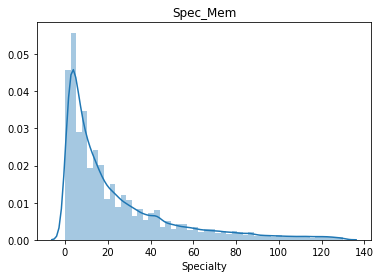

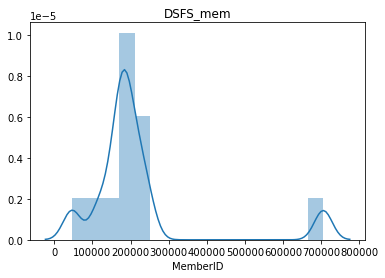

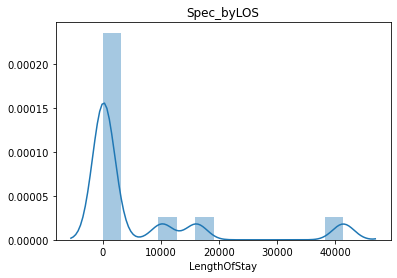

In [33]:
#Member_Specialty
Spec_bymem = claims[claims.PrimaryConditionGroup.notnull()].groupby("MemberID")['Specialty'].count().reset_index()
plt.figure(figsize = (6, 4))
sns.distplot(Spec_bymem['Specialty'])
plt. title ('Spec_Mem')

#Member_DSFS
DSFS_bymem = claims[claims.PrimaryConditionGroup.notnull()].groupby("DSFS")['MemberID'].count().reset_index()
plt.figure(figsize = (6, 4))
sns.distplot(DSFS_bymem['MemberID'])
plt. title ('DSFS_mem')

#Spec_LOS
Spec_byLOS = claims[claims.PrimaryConditionGroup.notnull()].groupby("Specialty")['LengthOfStay'].count().reset_index()
plt.figure(figsize = (6, 4))
sns.distplot(Spec_byLOS['LengthOfStay'])
plt. title ('Spec_byLOS')

<function matplotlib.pyplot.show(*args, **kw)>

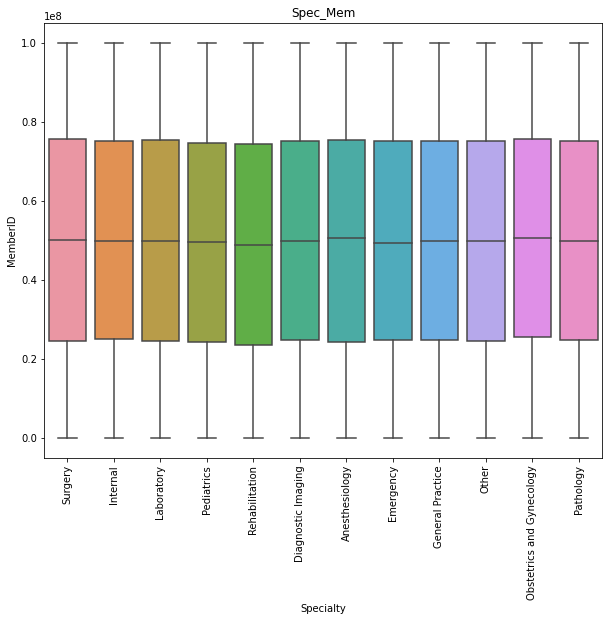

In [32]:
cond1 = claims.LengthOfStay.notnull()
cond2 = claims.Specialty.notnull()
Spec_LOS = claims[~claims.LengthOfStay.isin(cond1) | 
           claims.Specialty.isin(cond2)]
plt.figure(figsize = (10,8))
sns.boxplot(x=claims["Specialty"],y=claims["MemberID"],data=claims)
plt.xticks(rotation=90)
plt.title('Spec_Mem')
plt.show

In [26]:
claims[claims.LOS_converted.notnull()].groupby("PlaceSvc").LOS_converted.mean()
#Home (điều trị tại nhà), Other, và Inpatient Hospital (điều trị nội trú) có LOS cao hơn hẳn 

PlaceSvc
Ambulance              1.001
Home                  26.608
Inpatient Hospital     3.548
Office                 1.000
Other                 32.217
Outpatient Hospital    1.689
Urgent Care            1.106
Name: LOS_converted, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

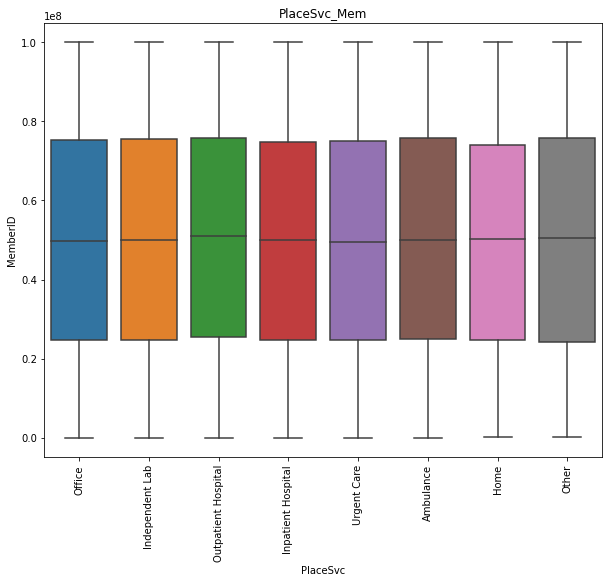

In [33]:
cond1 = claims.LengthOfStay.notnull()
cond2 = claims.PlaceSvc.notnull()
Spec_LOS = claims[~claims.LengthOfStay.isin(cond1) | 
           claims.PlaceSvc.isin(cond2)]
plt.figure(figsize = (10,8))
sns.boxplot(x=claims["PlaceSvc"],y=claims["MemberID"],data=claims)
plt.xticks(rotation=90)
plt.title('PlaceSvc_Mem')
plt.show

In [27]:
claims["PayDelay"].describe()
#PayDelay dạng object do có ngày 162+ 

count     2668990
unique        163
top             0
freq       141451
Name: PayDelay, dtype: object

In [28]:
#hàm bỏ dấu + ở PayDelay
def int_withoutmarks(s):
    try:
        if '+' in s:
            return int(s[:-1])
        if type(s) != int:
            return int(s)
    except:
        pass

In [29]:
int_withoutmarks('162+')

162

In [30]:
claims['PayDelay_ed']= claims["PayDelay"].apply(lambda x: int_withoutmarks(x))

In [53]:
claims[claims.LOS_converted.notnull()].groupby("PayDelay_ed").LOS_converted.mean()

PayDelay_ed
0      3.120
4      1.000
5      1.000
6      1.000
7      1.000
8      1.000
9      1.000
10     1.143
11     1.000
12     1.000
13     1.070
14     1.029
15     1.033
16     1.086
17     1.226
18     1.333
19     1.224
20     1.320
21     1.251
22     1.183
23     1.359
24     1.526
25     1.411
26     1.727
27     1.743
28     1.650
29     1.574
30     1.653
31     1.635
32     1.562
33     1.773
34     2.215
35     2.025
36     2.131
37     1.863
38     2.000
39     1.717
40     2.120
41     2.971
42     2.395
43     2.596
44     2.718
45     2.843
46     2.345
47     2.936
48     4.511
49     3.969
50     4.191
51     4.227
52     5.404
53     3.138
54     7.174
55    10.102
56     6.761
57     6.502
58     7.378
59     9.015
60     4.222
61     8.970
62     6.176
63     6.766
64     6.433
65     7.241
66     6.263
67     2.737
68     4.792
69     5.452
70     6.236
71     5.045
72     3.529
73     4.659
74     5.769
75     4.000
76     4.978
77     5.697
78     2.779


In [31]:
claims[claims.LOS_converted.notnull()].groupby("DSFS").LOS_converted.mean()
#Có thể không có sự chênh lệch đáng kể LOS giữa các bin của DSFS

DSFS
0- 1 month     2.238
1- 2 months    2.497
10-11 months   2.695
11-12 months   2.531
2- 3 months    2.500
3- 4 months    2.807
4- 5 months    2.841
5- 6 months    2.759
6- 7 months    2.830
7- 8 months    2.731
8- 9 months    2.711
9-10 months    2.568
Name: LOS_converted, dtype: float64

In [32]:
Primary_Condescription.head()

,PrimaryConditionGroup,Description
0,AMI,Acute myocardial infarction
1,APPCHOL,Appendicitis
2,ARTHSPIN,Arthropathies
3,CANCRA,Cancer A
4,CANCRB,Cancer B


In [26]:
claims[claims.LOS_converted.notnull()].groupby("PrimaryConditionGroup").LOS_converted.mean()

PrimaryConditionGroup
AMI         2.860
APPCHOL     1.745
ARTHSPIN    2.310
CANCRA      1.000
CANCRB      6.334
CATAST      5.633
CHF         2.190
COPD        1.546
FLaELEC     1.542
FXDISLC     1.223
GIBLEED     1.216
GIOBSENT    1.650
GYNEC1      1.587
GYNECA      1.321
HEART2      1.575
HEART4      1.679
HEMTOL      1.740
HIPFX       8.617
INFEC4      1.989
LIVERDZ     1.000
METAB1      1.550
METAB3      5.029
MISCHRT     1.080
MISCL1      1.391
MISCL5      1.145
MSC2a3      3.763
NEUMENT     1.085
ODaBNCA     1.117
PERINTL     1.000
PERVALV     5.426
PNCRDZ      2.298
PNEUM       4.336
PRGNCY      2.492
RENAL1      3.706
RENAL2     48.257
RENAL3      1.325
RESPR4      1.150
ROAMI       1.441
SEIZURE     1.261
SEPSIS      6.462
SKNAUT      5.025
STROKE     12.214
TRAUMA      1.448
UTI         1.494
Name: LOS_converted, dtype: float64

In [38]:
#Tạo bảng giữa condition và số lượng member, số lượng ngày nằm viện và so sánh quan hệ. Tất cả đều chỉ tính trên những dòng có LOS
claims1 = claims[claims.LOS_converted.notnull()].groupby("PrimaryConditionGroup")['LOS_converted'].sum()

claims2 = claims[claims.LOS_converted.notnull()].groupby("PrimaryConditionGroup")['MemberID'].count()

claim_merge1 = pd.merge(claims1, claims2, on=['PrimaryConditionGroup'])

claims3 = claims[claims.LOS_converted.notnull()].groupby("PrimaryConditionGroup").LOS_converted.mean()

claim_merge2 = pd.merge(claim_merge1,claims3, on=['PrimaryConditionGroup'])

claim_merge2.rename(columns={"LOS_converted_x": "LOS_count", "LOS_converted_y": "LOS_mean"},inplace=True)

#Filter theo: LOS_count > 10000 ngày hoặc LOS_mean > 2 ngày
#2 điều kiện
cond1 = claim_merge2.LOS_count >= 10000
cond2 = claim_merge2.LOS_mean >=2
claim_merge2cond = claim_merge2[~claim_merge2.LOS_count.isin(cond1) | 
           claim_merge2.LOS_mean.isin(cond2)]
#Xếp giảm dần theo LOS_mean
sort_by_LOS_mean = claim_merge2cond.sort_values('LOS_mean',ascending=False)
sort_by_LOS_mean

#Các condition đáng chú ý (tổng nhiều ngày nằm viện và trung bình 1 người nằm nhiều)
#RENAL2 (suy thận mãn tính), 
#STROKE (đứt mạch máu não), 
#HIPFX(gãy xương hông), 
#SEPSIS (giảm huyết áp đột ngột do chấn thương), 
#CANCRB (ung thư có di căn, hoặc Hodgkin và có xạ hóa trị)



,LOS_count,MemberID,LOS_mean
PrimaryConditionGroup,,,
RENAL2,35614.000,738,48.257
STROKE,4556.000,373,12.214
HIPFX,2292.000,266,8.617
SEPSIS,168.000,26,6.462
CANCRB,3072.000,485,6.334
CATAST,338.000,60,5.633
PERVALV,293.000,54,5.426
METAB3,2288.000,455,5.029
SKNAUT,4236.000,843,5.025


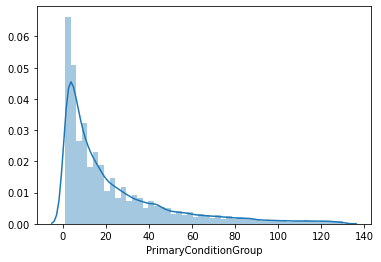

In [33]:
Condition_bymem = claims[claims.PrimaryConditionGroup.notnull()].groupby("MemberID")['PrimaryConditionGroup'].count().reset_index()
sns.distplot(Condition_bymem['PrimaryConditionGroup'])


<function matplotlib.pyplot.show(*args, **kw)>

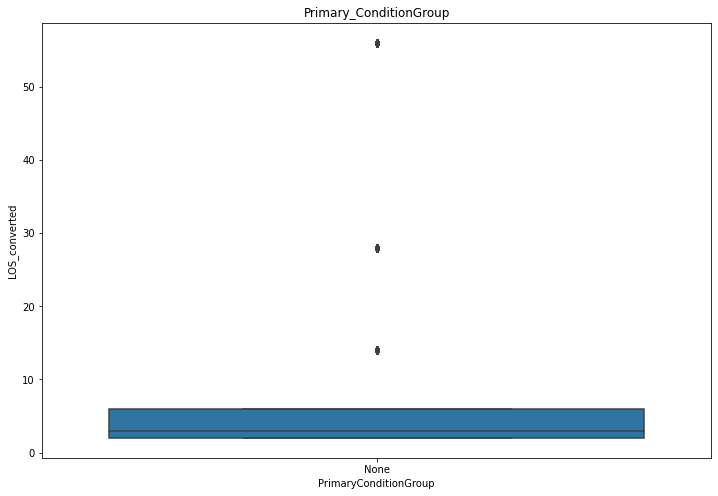

In [85]:
cond1 = claims.LOS_converted.notnull()
cond2 = claims.PrimaryConditionGroup.notnull()
CondGroup_LOS = claims[~claims.LOS_converted.isin(cond1) | 
           claims.PrimaryConditionGroup.isin(cond2)]
plt.figure(figsize = (12,8))
sns.boxplot(x=CondGroup_LOS["PrimaryConditionGroup"],y=CondGroup_LOS["LOS_converted"],data=claims)
plt.title('Primary_ConditionGroup')
plt.show

In [72]:
claims[claims.LOS_converted.notnull()].groupby("CharlsonIndex").LOS_converted.mean()

CharlsonIndex
0     1.647
1-2   3.642
3-4   7.133
5+    2.471
Name: LOS_converted, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

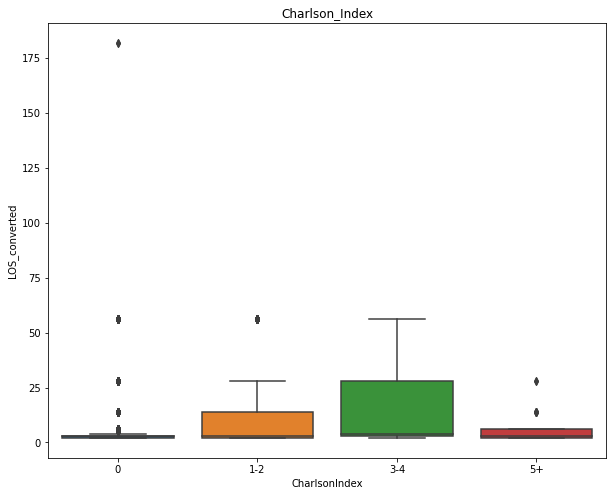

In [79]:
#Sự liên quan giữa Charlson Index và LOS
cond1 = claims.LOS_converted.notnull()
cond2 = claims.CharlsonIndex.notnull()
Charlson_LOS = claims[~claims.LOS_converted.isin(cond1) | 
           claims.CharlsonIndex.isin(cond2)]
plt.figure(figsize = (10,8))
sns.boxplot(x=Charlson_LOS["CharlsonIndex"],y=Charlson_LOS["LOS_converted"],data=claims)
plt.title('Charlson_Index')
plt.show

In [55]:
claims[claims.LOS_converted.notnull()].groupby("ProcedureGroup").LOS_converted.mean()

ProcedureGroup
ANES    2.350
EM      7.722
MED     3.457
PL     46.844
RAD     1.305
SCS     1.269
SDS     1.539
SEOA    3.034
SGS    25.842
SIS     4.673
SMS     2.577
SNS    10.956
SO      1.156
SRS     1.139
SUS     1.644
Name: LOS_converted, dtype: float64